In [33]:
# ! pip install newsapi-python

In [34]:
import os

from newsapi import NewsApiClient
from tqdm import tqdm

from keybert import KeyBERT

import pandas as pd
import pickle

from itertools import chain
from collections import Counter

import datetime as DT

In [63]:
# api request를 정하는 부분으로 신중하게 확인할
from_date = '2023-05-17'
to_date = '2023-05-23'
query = 'finance OR banking OR economy OR sustainability'
pages = range(1,6) # 무료 api는 일일당 5page가 최대.

In [64]:
# 환경 설정
cwd = os.getcwd()
main_path = cwd + '/' + query 

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder(main_path)
createFolder(main_path + '/' + 'dataByDate')

In [65]:
# 데이터 수집(api)
f=open(r"C:\Users\NH\Desktop\newsapi_api_ key.txt","rt")
while True:
    api_key = f.read() 
    break
f.close()

In [66]:
# api 횟수가 차감되는 부분으로 신중히 돌릴것
newsapi = NewsApiClient(api_key=api_key)
news = []
urls = []
dates = []
for page in pages:
    print(page)
    all_articles = newsapi.get_everything(q=query,
                                          from_param=from_date ,
                                          to=to_date,
                                          language='en',
                                          sort_by='relevancy',
                                          page=page)

    for article in all_articles['articles']:
        
        title = article['title']
        description = article['description']
        content = '. '.join([title,description]) if description != None and title != None else '' 
        
        url = article['url']
        
        publishedAt = article['publishedAt'][:10]
        
        news.append(content)
        urls.append(url)
        dates.append(publishedAt)

1
2
3
4
5


In [67]:
# 키워드 추출

def doc2key(content,kw_model):
    
    keywords = kw_model.extract_keywords(content, keyphrase_ngram_range=(1, 1), use_mmr=True,diversity=0.7,stop_words='english', top_n=10)
    
    keywords = [a[0] for a in keywords if a[1] >= 0.25 ]
    
    return keywords

kw_model = KeyBERT(model='all-MiniLM-L6-v2')
keywords = []
for content in tqdm(news):
    keyword = doc2key(content,kw_model)
    keywords.append(keyword)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:27<00:00, 18.46it/s]


In [68]:
# html에서 추출한 정보를 dataframe으로 만들고 저장.
data = pd.DataFrame({'date':dates,'news':news,'url':urls,'keyword':keywords})

name = "dataByDate_{}_{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'dataByDate/' + name,'wb') as f:
    pickle.dump(data,f)

In [69]:
# 키워드 카운트
DataCountByDay = pd.DataFrame(Counter(list(chain(*data['keyword'].values))),index = [from_date])

In [71]:
data.head()

date                                               news  \
0  2023-05-20  El Niño could take a $3 trillion bite out of t...   
1  2023-05-19  Nobel economist Paul Krugman says he's worried...   
2  2023-05-17  Bank of England governor admits UK economy suf...   
3  2023-05-19  'Rich Dad Poor Dad' author Robert Kiyosaki war...   
4  2023-05-23  Developing Leaders And Entrepreneurs For The “...   

                                                 url  \
0  https://www.theverge.com/2023/5/20/23730210/el...   
1  https://markets.businessinsider.com/news/stock...   
2  https://consent.google.com/ml?continue=https:/...   
3  https://markets.businessinsider.com/news/curre...   
4  https://www.forbes.com/sites/christophermarqui...   

                                             keyword  
0                  [economic, 2023, trillions, niño]  
1                          [inflation, krugman, fed]  
2                             [inflation, bank, boe]  
3  [bitcoin, economy, investors, crash, downturn,...  
4  [mba, entrepreneurs, honeyman, sustainability,...

In [72]:
DataCountByDay = DataCountByDay.T

In [73]:
# 워드 클라우드
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from wordcloud import (WordCloud, get_single_color_func)
import numpy as np
def DrawPointColoredWC(tags,title,cwd,searching_word, drop_list=[], color = '#00ff00', pointed_list=[]):
    color_to_words = {
        color : pointed_list
    }

    use_tags = tags.drop(drop_list, errors = 'ignore')
    wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800,random_state = 1)

    default_color = 'black'
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)

    cloud = wc.generate_from_frequencies(dict(use_tags))
    wc.recolor(color_func=grouped_color_func)

    figure(dpi=1200)
    figure(figsize=[12,8])
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig(cwd + '/' + searching_word + '/'+ title + ' 강조'+'.pdf')
    plt.show()
    
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [74]:
# 최대 키워드 수, 지울 단어, 강조할 단어 지정
num_exp = 50
drop_list = [np.nan,'2023','2022','thomson','httpswww','review','review terms','sure','reuters','terms','theres','happen','cookies','content','javascript','browser','supports javascript','did happen','loading information']
num = num_exp + len(drop_list)
color_to_words = {
    '#00ff00': []
}

In [75]:
'''
DataCountByDay = DataCountByDay.T
DataCountByDay['META'] = 50
DataCountByDay['GDP'] = 40
DataCountByDay['EU'] = 30
DataCountByDay = DataCountByDay.T
DataCountByDay
'''

2023-05-17에서 2023-05-23까지 키워드 출현 빈도 순 상위 50개 입니다


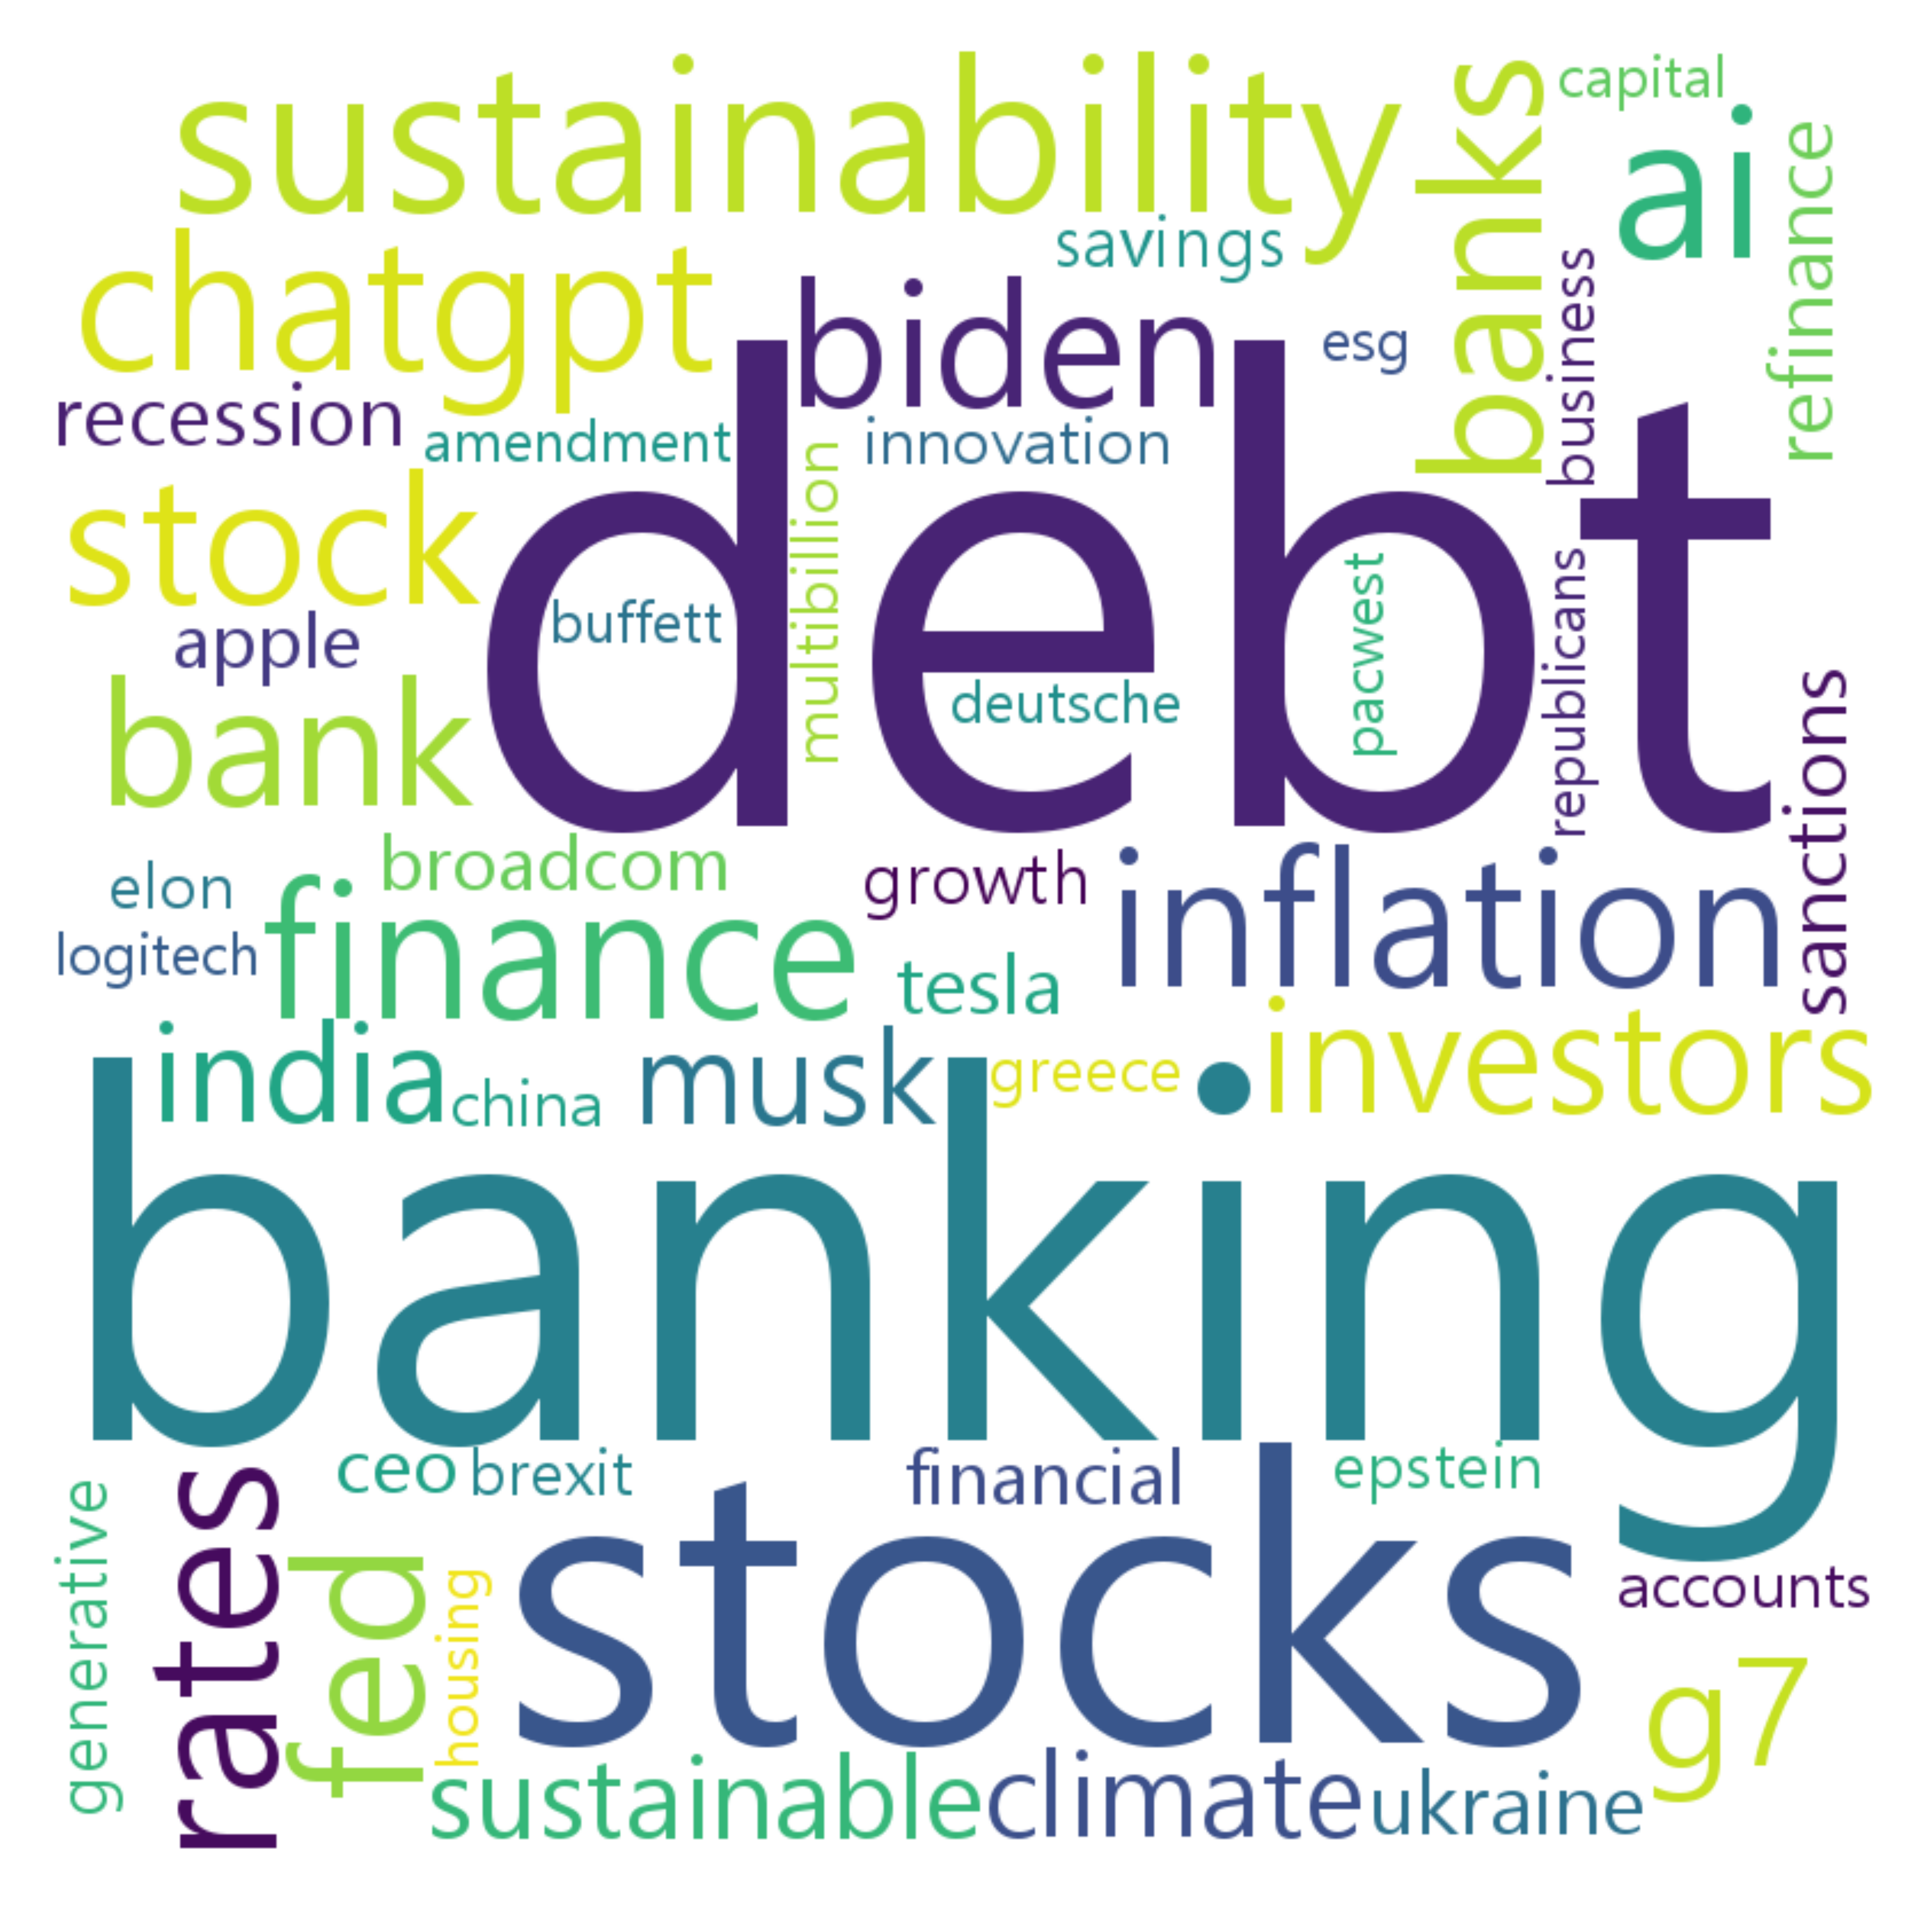

In [92]:
# 그림 그리기 및 저장
tags = DataCountByDay.sort_values(by = from_date, ascending = False)[1:num+1][from_date]
tags = tags.drop(drop_list, errors = 'ignore')[:num_exp]
print('{}에서 {}까지 키워드 출현 빈도 순 상위 {}개 입니다'.format(from_date,to_date,num_exp))
wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=800, height=800,random_state = 1)
# default_color = 'black'
# grouped_color_func = GroupedColorFunc(color_to_words, default_color)

cloud = wc.generate_from_frequencies(dict(tags))
# wc.recolor(color_func=grouped_color_func)

figure(dpi=1200)
title = '대상기간_최대출현_키워드_{}개'.format(str(len(tags)))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(cwd + '/' + query + '/'+ title + from_date + '.pdf')
plt.show()

In [168]:
# api request를 정하는 부분으로 신중하게 확인할
from_date = '2023-05-17'
to_date = '2023-05-23'
query = '금융 OR 은행 OR 경제 OR 지속가능성'
pages = range(1,6) # 무료 api는 일일당 5page가 최대.

In [164]:
# 환경 설정
cwd = os.getcwd()
main_path = cwd + '/' + query 

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder(main_path)
createFolder(main_path + '/' + 'dataByDate')

In [165]:
query

'금융'

In [166]:
# api 횟수가 차감되는 부분으로 신중히 돌릴것
newsapi = NewsApiClient(api_key=api_key)
news = []
urls = []
dates = []
for page in pages:
    print(page)
    all_articles = newsapi.get_everything(q=query,
                                          from_param=from_date ,
                                          to=to_date,
                                          sort_by='relevancy',
                                          page=page)

    for article in all_articles['articles']:
        
        title = article['title']
        description = article['description']
        content = '. '.join([title,description]) if description != None and title != None else '' 
        
        url = article['url']
        
        publishedAt = article['publishedAt'][:10]
        
        news.append(content)
        urls.append(url)
        dates.append(publishedAt)

1
2
3
4
5


In [167]:
# 키워드 추출

def doc2key(content,kw_model):
    
    keywords = kw_model.extract_keywords(content, keyphrase_ngram_range=(1, 1), use_mmr=True,diversity=0.7,stop_words='english', top_n=10)
    
    keywords = [a[0] for a in keywords if a[1] >= 0.25 ]
    
    return keywords

kw_model = KeyBERT(model='snunlp/KR-SBERT-V40K-klueNLI-augSTS')
keywords = []
for content in tqdm(news):
    keyword = doc2key(content,kw_model)
    keywords.append(keyword)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]


In [153]:
keywords

[['자동차금융', '카드사별캐시백', '벤처스퀘어', 'appeared', '서비스', '핀크', '비교', '출시한다'],
 ['최적지출컨설팅', '스타트업들의', '법인카드', '모니터링해'],
 ['table'],
 ['kb국민은행의', '업무협약', '페이워치', 'bukopin', '인도네시아', '115개'],
 ['리더', '벤처스퀘어', '아시아의', '박규태', 'appeared', '포브스', '30세', '2011년부터', '경제전문지'],
 [],
 ['스타트업의', '뉴튠', '결선에서'],
 ['시장금리로', '오르락', '한마디에', '시점이었다'],
 ['경제장관회의', 'table', '중국대사와'],
 ['원로들'],
 [],
 ['항공사들의', '수익성', '2023', '10가지', '난제', '극복해야'],
 ['부채한도'],
 ['12개월', '옐런', '불확실성'],
 ['챗gpt가', '인공지능', '월가에서도'],
 ['14개월'],
 ['플랫폼에서', '블록체인을'],
 ['플랫폼', '캡스홈', '하나은행', '보안', 'sk쉴더스', '협력'],
 ['크레디스위스'],
 ['금감원장의', '새희망홀씨대출', '오르내렸다면', '금리가'],
 ['경기도지사가', '새싹기업'],
 ['비즈마켓', 'hellip', 'lg유플러스는', '고객들이', '분야별'],
 ['전세사기고충접수센터', '솔루션2045포럼', '권지웅'],
 ['인증통합서비스', '이니텍은', 'kt그룹'],
 ['카카오모빌리티'],
 ['18민주묘지에서', '오월의', '계승한다면', '제43주년', '우린', '자유민주주의를'],
 ['자평했다', '윤석열', '일장연설'],
 ['경남도당'],
 ['성평등과'],
 ['대면수업조차', '코로나19로'],
 ['개악', '상생임금위원회'],
 ['자동화되고', '모바일을'],
 ['원도심', '민선8기', '추진돼야', '균형과', '상반기를'],
 ['공동기자회견에서', '협력', '60

In [154]:
# html에서 추출한 정보를 dataframe으로 만들고 저장.
data = pd.DataFrame({'date':dates,'news':news,'url':urls,'keyword':keywords})

name = "dataByDate_{}_{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'dataByDate/' + name,'wb') as f:
    pickle.dump(data,f)

In [155]:
# 키워드 카운트
DataCountByDay = pd.DataFrame(Counter(list(chain(*data['keyword'].values))),index = [from_date])

In [156]:
DataCountByDay = DataCountByDay.T

In [157]:
# 워드 클라우드
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from wordcloud import (WordCloud, get_single_color_func)
import numpy as np
def DrawPointColoredWC(tags,title,cwd,searching_word, drop_list=[], color = '#00ff00', pointed_list=[]):
    color_to_words = {
        color : pointed_list
    }

    use_tags = tags.drop(drop_list, errors = 'ignore')
    wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800,random_state = 1)

    default_color = 'black'
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)

    cloud = wc.generate_from_frequencies(dict(use_tags))
    wc.recolor(color_func=grouped_color_func)

    figure(dpi=1200)
    figure(figsize=[12,8])
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig(cwd + '/' + searching_word + '/'+ title + ' 강조'+'.pdf')
    plt.show()
    
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [158]:
# 최대 키워드 수, 지울 단어, 강조할 단어 지정
num_exp = 50
drop_list = [np.nan,'2023','2022','thomson','httpswww','review','review terms','sure','reuters','terms','theres','happen','cookies','content','javascript','browser','supports javascript','did happen','loading information']
num = num_exp + len(drop_list)
color_to_words = {
    '#00ff00': []
}

2023-05-17에서 2023-05-23까지 키워드 출현 빈도 순 상위 50개 입니다


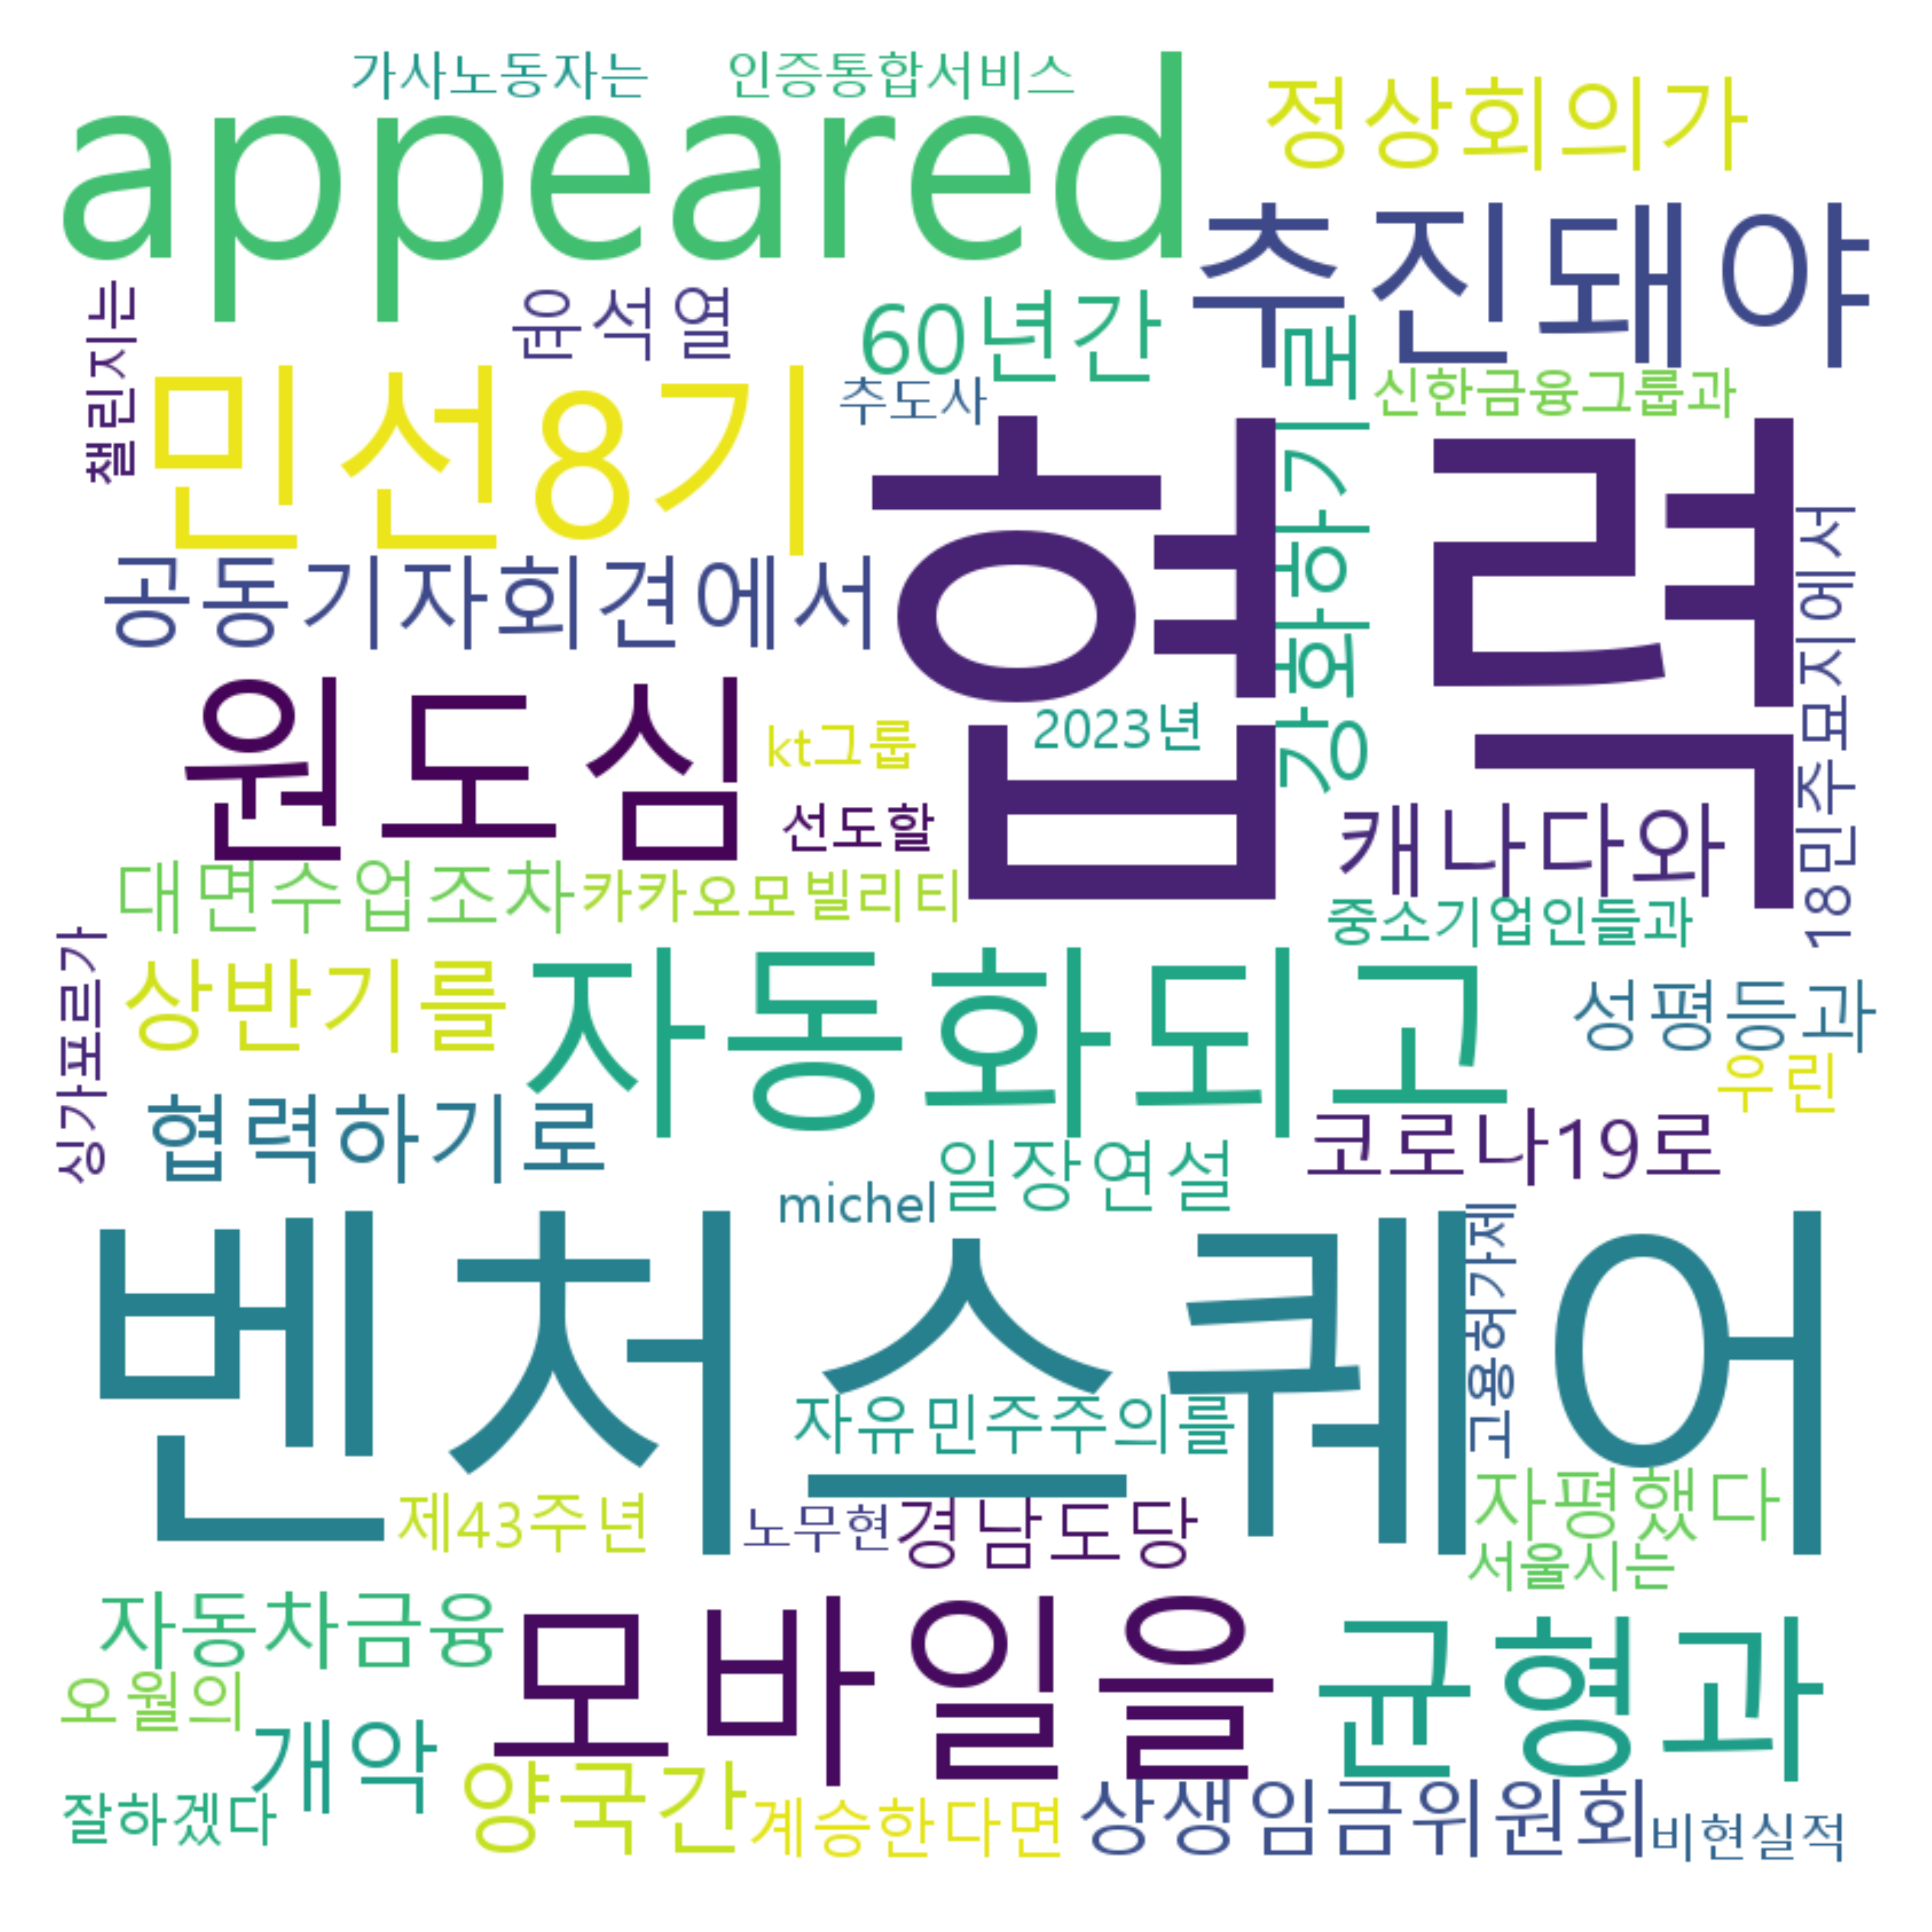

In [159]:
# 그림 그리기 및 저장
tags = DataCountByDay.sort_values(by = from_date, ascending = False)[1:num+1][from_date]
tags = tags.drop(drop_list, errors = 'ignore')[:num_exp]
print('{}에서 {}까지 키워드 출현 빈도 순 상위 {}개 입니다'.format(from_date,to_date,num_exp))
wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=800, height=800,random_state = 1)
# default_color = 'black'
# grouped_color_func = GroupedColorFunc(color_to_words, default_color)

cloud = wc.generate_from_frequencies(dict(tags))
# wc.recolor(color_func=grouped_color_func)

figure(dpi=1200)
title = '대상기간_최대출현_키워드_{}개'.format(str(len(tags)))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(cwd + '/' + query + '/'+ title + from_date + '.pdf')
plt.show()

In [47]:
'''
# 일주일 평균 대비 상승 키워드 
# 모든 데이터를 로딩
data_path = cwd + '/' + query +'/' + 'dataByDate'
file_list = os.listdir(data_path)

dfs = []
for i in file_list:
    with open(data_path + '/' + i, 'rb') as f:
        df = pickle.load(f)
    dfs.append(df)
    
data = pd.concat(dfs)

week_ago = norm_day - DT.timedelta(days=6)
norm_day = norm_day.strftime("%Y-%m-%d")
week_ago = week_ago.strftime("%Y-%m-%d")

norm_day = DT.date.today() - DT.timedelta(days=delay)

df = data.set_index('date').loc[week_ago:norm_day]
melted = df.melt(id_vars=['news'], value_vars=['keyword'], var_name='keyword')
# explode 함수를 사용하여 리스트를 풉니다.
exploded = df.explode('keyword')
# 일별로 키워드를 카운팅합니다.
cnt = exploded.groupby(['date','keyword'])['keyword'].count().reset_index(name='count')

pivot_table = pd.pivot_table(cnt, values='count', index='keyword', columns='date', fill_value=0)
df = pivot_table.copy()
df['mean'] = pivot_table.mean(axis = 1)

divisor = 'mean'

new_df = df.div(df[divisor], axis=0)

df['compared_to_average'] = new_df[norm_day]

top_cnt = df.sort_values(ascending= False, by = norm_day)[0:50]
top_cnt = top_cnt[top_cnt['compared_to_average'] > 1.1]
top_cnt = top_cnt.sort_values(ascending= False, by = 'compared_to_average')
df.sort_values(ascending= False, by = norm_day)[0:50]

keyword = 'cloud'

tmp = []
for i in data ['keyword']:
    if keyword in i:
        tmp.append(True)
    else:
        tmp.append(False)
        
result = data[tmp]
result = result[result['date'] == norm_day]

for url in data['url']:
    print(url)
'''

'\n# 일주일 평균 대비 상승 키워드 \n# 모든 데이터를 로딩\ndata_path = cwd + \'/\' + query +\'/\' + \'dataByDate\'\nfile_list = os.listdir(data_path)\n\ndfs = []\nfor i in file_list:\n    with open(data_path + \'/\' + i, \'rb\') as f:\n        df = pickle.load(f)\n    dfs.append(df)\n    \ndata = pd.concat(dfs)\n\nweek_ago = norm_day - DT.timedelta(days=6)\nnorm_day = norm_day.strftime("%Y-%m-%d")\nweek_ago = week_ago.strftime("%Y-%m-%d")\n\nnorm_day = DT.date.today() - DT.timedelta(days=delay)\n\ndf = data.set_index(\'date\').loc[week_ago:norm_day]\nmelted = df.melt(id_vars=[\'news\'], value_vars=[\'keyword\'], var_name=\'keyword\')\n# explode 함수를 사용하여 리스트를 풉니다.\nexploded = df.explode(\'keyword\')\n# 일별로 키워드를 카운팅합니다.\ncnt = exploded.groupby([\'date\',\'keyword\'])[\'keyword\'].count().reset_index(name=\'count\')\n\npivot_table = pd.pivot_table(cnt, values=\'count\', index=\'keyword\', columns=\'date\', fill_value=0)\ndf = pivot_table.copy()\ndf[\'mean\'] = pivot_table.mean(axis = 1)\n\ndivisor = \'mean\'\

In [48]:
'''
# 뉴스 검색기능(구현예정)
keyword = 'savings'

tmp = []
for i in keyword_long_data['keyword']:
    if keyword in i:
        tmp.append(True)
    else:
        tmp.append(False)

for url in url_long_data[tmp]['url']:
    print(url)
'''

"\n# 뉴스 검색기능(구현예정)\nkeyword = 'savings'\n\ntmp = []\nfor i in keyword_long_data['keyword']:\n    if keyword in i:\n        tmp.append(True)\n    else:\n        tmp.append(False)\n\nfor url in url_long_data[tmp]['url']:\n    print(url)\n"